<a href="https://colab.research.google.com/github/asdflazaro/Cow_Science_Robots/blob/main/ACC_vs_ACC%2BTilt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [144]:
#Baixar e instalar o skopt
!pip install scikit-learn==1.0.0 -q -U
!pip install git+https://github.com/scikit-optimize/scikit-optimize.git -q -U

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [220]:
# Imports
import numpy as np
import pandas as pd
import skopt

In [221]:
# Leitura e amostra da tabela
df = pd.read_csv('Tabela.all.csv', delimiter = ';')
df.head()

,Data,Hora,ax,ay,az,gx,gy,gz,Comportamento
0,27/01/2023,04:45:00,11669,5323,6348,1695,2941,-2270,1
1,27/01/2023,04:45:01,11130,7025,7761,-2178,-1819,2134,1
2,27/01/2023,04:45:02,10120,6610,10145,-2487,185,1868,1
3,27/01/2023,04:45:03,13629,3053,7777,-837,-4725,-3067,1
4,27/01/2023,04:45:04,13537,3296,7080,1245,-2580,571,1


In [222]:
# Exibe os tipos presentes na tabela
df.dtypes

Data             object
Hora             object
ax                int64
ay                int64
az                int64
gx                int64
gy                int64
gz                int64
Comportamento     int64
dtype: object

In [223]:
# Imports
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from skopt import gp_minimize

In [224]:
# Exibe as colunas existentes
df.columns

Index(['Data', 'Hora', 'ax', 'ay', 'az', 'gx', 'gy', 'gz ', 'Comportamento'], dtype='object')

**ACC + Tilt**

In [150]:
# Lista com os atributos aplicáveis - colunas
features_aplicaveis = ['ax', 'ay' ,'az', 'gx', 'gy', 'gz ', 'Comportamento']

In [151]:
# Seleciona os abributos correspondentes da lista features_aplicaveis
df = df[features_aplicaveis]

In [152]:
def imprimir_quantidade_dados(X_train, X_test):
    print(10*"-"," Quantidade de dados ",  10*"-")
    
    print('Treino: ', X_train.shape[0])
    print('Teste: ', X_test.shape[0])
    
    print(43*"-")

In [153]:
y = df.Comportamento
X = df.drop('Comportamento', axis=1)

# Conjunto de dados PRO: Pastejando x Ruminando x Ócio
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state = 0, stratify=y)

In [154]:
imprimir_quantidade_dados(X_train, X_test)

----------  Quantidade de dados  ----------
Treino:  62896
Teste:  15725
-------------------------------------------


In [155]:
# Função para imprimir e salvar matriz de confusão
def imprimeMatrizDeConfusão(y_test, preds, model, salvarFigura = False):
    from sklearn.metrics import confusion_matrix
    from sklearn.metrics import ConfusionMatrixDisplay
    import matplotlib.pyplot as plt

    cm = confusion_matrix(y_test, preds, normalize='true')
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    disp.plot(values_format= '.2%', xticks_rotation=60, colorbar=False)
    disp.ax_.set_title("Matriz de confusão normalizada sobre as condições verdadeiras")
    if(salvarFigura):
        plt.savefig(input('Nome da figura a ser salva:' ) + '.png')
    plt.show()

In [156]:
from sklearn.metrics import classification_report

def classification_report_extendido(y_true: np.array, y_pred: np.array, classes: set = None):
    report = classification_report(y_true, y_pred, output_dict=True, zero_division=0)
    
    if classes is None: # Determina classes pelos valores
        classes = set(np.concatenate((np.unique(y_true), np.unique(y_pred))))
    for cls in classes:
        y_true_cls = (y_true == cls).astype(int)
        y_pred_cls = (y_pred == cls).astype(int)

        fp = sum(y_pred_cls[y_true_cls != 1])
        tn = sum(y_pred_cls[y_true_cls == 0] == False)
        fn = sum(y_pred_cls[y_true_cls == 1] == False)

        
        specificity_val = tn / (tn + fp)
        report[cls]['specificity'] = specificity_val
        npv_val = tn / (tn + fn)
        report[cls]['npv'] = npv_val
        
    return report

RF

In [157]:
# imports
from sklearn.ensemble import RandomForestClassifier

In [158]:
rf_Model = RandomForestClassifier(random_state=0, n_jobs=-1)

In [159]:
# criação de um grid
rf_param_grid = {'n_estimators':  np.arange(50, 250, 50),
               'max_features': ['auto', 'sqrt'],
               'max_depth':[50, 100, 150, None],
               'criterion': ['gini', 'entropy'],
               'min_samples_split': [2, 5, 10, 30, 50],
               'min_samples_leaf': [1, 2],
               'bootstrap': [True, False]}

In [160]:
rf_RandomGrid = RandomizedSearchCV(estimator = rf_Model, param_distributions = rf_param_grid, cv = 3, verbose=1, random_state=0)

In [163]:
# Identificação do melhor hiperparametro para testes iniciais
%%time
rf_RandomGrid.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
CPU times: user 1min 8s, sys: 5.21 s, total: 1min 13s
Wall time: 10min 45s


RandomizedSearchCV(cv=3,
                   estimator=RandomForestClassifier(n_jobs=-1, random_state=0),
                   param_distributions={'bootstrap': [True, False],
                                        'criterion': ['gini', 'entropy'],
                                        'max_depth': [50, 100, 150, None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2],
                                        'min_samples_split': [2, 5, 10, 30, 50],
                                        'n_estimators': array([ 50, 100, 150, 200])},
                   random_state=0, verbose=1)

In [164]:
# Retorna o melhor hiperparametro
rf_RandomGrid.best_params_

{'n_estimators': 50,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': None,
 'criterion': 'entropy',
 'bootstrap': True}

In [165]:
# Acurácia com o melhor hiperparametro pata teste inicial
rf_RandomGrid.best_score_

0.7592374919877735

In [166]:
preds_rf_RG = rf_RandomGrid.predict(X_test)

In [167]:
accuracy_score(y_test, preds_rf_RG)*100

77.35453100158982

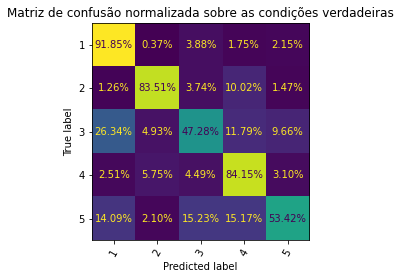

In [168]:
imprimeMatrizDeConfusão(y_test, preds_rf_RG, rf_RandomGrid)

In [169]:
## Busca pelo melho hiperparametro ##
def tune_rf(params):
    n_estimators = params[0]
    max_features = params[1]
    max_depth = params[2]
    criterion = params[3]
    min_samples_split = params[4]
    min_samples_leaf = params[5]
    bootstrap = params[6]
    
    print(params, '\n')
    
    rf_Model = RandomForestClassifier(n_estimators=n_estimators, max_features=max_features, max_depth=max_depth, criterion=criterion, min_samples_split=min_samples_split,
                                       min_samples_leaf = min_samples_leaf, bootstrap=bootstrap, random_state=0, n_jobs=-1)
    
    auc = cross_val_score(rf_Model, X_train, y_train, cv=3, scoring ='accuracy')
    
    return -auc.mean()

space = [ np.arange(50, 250, 50), # n_estimators
         ['auto', 'sqrt'], # max_features
         [50, 100, 150, None], # max_depth
         ['gini', 'entropy'], # criterion
         [2, 5, 10, 30, 50], # min_samples_split
         [1,2,4], # min_samples_leaf
         [True, False]] # bootstrap] 

In [170]:
%%time
from skopt import forest_minimize
resultado_rf = gp_minimize(tune_rf, space, random_state=0, verbose=1, n_calls=30, n_random_starts=15, n_jobs=-1)

Iteration No: 1 started. Evaluating function at random point.
[150, 'sqrt', None, 'gini', 10, 2, False] 

Iteration No: 1 ended. Evaluation done at random point.
Time taken: 70.7086
Function value obtained: -0.7609
Current minimum: -0.7609
Iteration No: 2 started. Evaluating function at random point.
[50, 'auto', 100, 'gini', 10, 2, True] 

Iteration No: 2 ended. Evaluation done at random point.
Time taken: 16.2093
Function value obtained: -0.7579
Current minimum: -0.7609
Iteration No: 3 started. Evaluating function at random point.
[100, 'sqrt', 100, 'gini', 5, 4, False] 

Iteration No: 3 ended. Evaluation done at random point.
Time taken: 45.8967
Function value obtained: -0.7596
Current minimum: -0.7609
Iteration No: 4 started. Evaluating function at random point.
[150, 'sqrt', 150, 'gini', 10, 2, True] 

Iteration No: 4 ended. Evaluation done at random point.
Time taken: 45.3603
Function value obtained: -0.7601
Current minimum: -0.7609
Iteration No: 5 started. Evaluating function at

In [171]:
# Retorna o melhor hiperparametro
# Em ordem: n_estimators, max_features, max_depth, criterion, min_samples_split, min_samples_leaf, bootstrap
resultado_rf.x

[200, 'auto', 50, 'entropy', 10, 1, False]

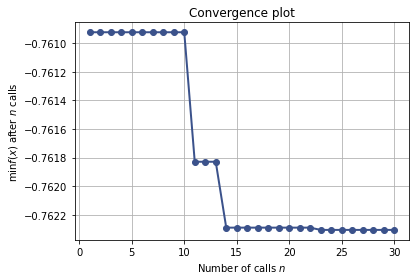

In [172]:
from skopt.plots import plot_convergence
plot_convergence(resultado_rf)

In [173]:
# Inserir manualmente os melhores hiperparametros
%%time
rf_model = RandomForestClassifier(n_estimators=200, max_features='auto', max_depth=50, criterion='entropy',
                                  min_samples_split=10, min_samples_leaf=1 , bootstrap=False, random_state=0, n_jobs=-1)
rf_model.fit(X_train, y_train)
preds = rf_model.predict(X_test)

CPU times: user 1min 51s, sys: 261 ms, total: 1min 51s
Wall time: 1min 8s


In [174]:
# Retorna a acurácia
accuracy_score(y_test, preds)*100

77.6852146263911

In [175]:
# Retorna a tabela com alguns resultados
# digits= define quantidade de casas após a virgula
print(classification_report(y_test, preds, digits=4))

              precision    recall  f1-score   support

           1     0.8228    0.9156    0.8667      5153
           2     0.8697    0.8319    0.8504      2784
           3     0.6287    0.4740    0.5405      2536
           4     0.7690    0.8516    0.8082      3584
           5     0.6413    0.5564    0.5958      1668

    accuracy                         0.7769     15725
   macro avg     0.7463    0.7259    0.7323     15725
weighted avg     0.7683    0.7769    0.7691     15725



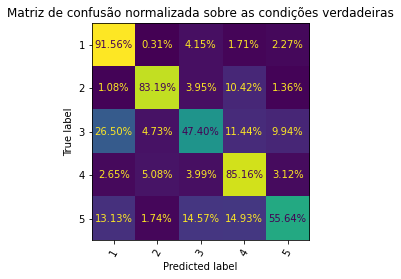

In [176]:
imprimeMatrizDeConfusão(y_test, preds, rf_model)

**ACC**

In [177]:
# Lista com os atributos aplicáveis - colunas
features_aplicaveis = ['ax', 'ay' ,'az', 'Comportamento']

In [178]:
# Seleciona os abributos correspondentes da lista features_aplicaveis
df = df[features_aplicaveis]

In [179]:
def imprimir_quantidade_dados(X_train, X_test):
    print(10*"-"," Quantidade de dados ",  10*"-")
    
    print('Treino: ', X_train.shape[0])
    print('Teste: ', X_test.shape[0])
    
    print(43*"-")

In [180]:
y = df.Comportamento
X = df.drop('Comportamento', axis=1)

# Conjunto de dados PRO: Pastejando x Ruminando x Ócio
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state = 0, stratify=y)

In [181]:
imprimir_quantidade_dados(X_train, X_test)

----------  Quantidade de dados  ----------
Treino:  62896
Teste:  15725
-------------------------------------------


In [182]:
# Função para imprimir e salvar matriz de confusão
def imprimeMatrizDeConfusão(y_test, preds, model, salvarFigura = False):
    from sklearn.metrics import confusion_matrix
    from sklearn.metrics import ConfusionMatrixDisplay
    import matplotlib.pyplot as plt

    cm = confusion_matrix(y_test, preds, normalize='true')
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    disp.plot(values_format= '.2%', xticks_rotation=60, colorbar=False)
    disp.ax_.set_title("Matriz de confusão normalizada sobre as condições verdadeiras")
    if(salvarFigura):
        plt.savefig(input('Nome da figura a ser salva:' ) + '.png')
    plt.show()

In [183]:
from sklearn.metrics import classification_report

def classification_report_extendido(y_true: np.array, y_pred: np.array, classes: set = None):
    report = classification_report(y_true, y_pred, output_dict=True, zero_division=0)
    
    if classes is None: # Determina classes pelos valores
        classes = set(np.concatenate((np.unique(y_true), np.unique(y_pred))))
    for cls in classes:
        y_true_cls = (y_true == cls).astype(int)
        y_pred_cls = (y_pred == cls).astype(int)

        fp = sum(y_pred_cls[y_true_cls != 1])
        tn = sum(y_pred_cls[y_true_cls == 0] == False)
        fn = sum(y_pred_cls[y_true_cls == 1] == False)

        
        specificity_val = tn / (tn + fp)
        report[cls]['specificity'] = specificity_val
        npv_val = tn / (tn + fn)
        report[cls]['npv'] = npv_val
        
    return report

RF

In [184]:
# imports
from sklearn.ensemble import RandomForestClassifier

In [185]:
rf_Model = RandomForestClassifier(random_state=0, n_jobs=-1)

In [186]:
# criação de um grid
rf_param_grid = {'n_estimators':  np.arange(50, 250, 50),
               'max_features': ['auto', 'sqrt'],
               'max_depth':[50, 100, 150, None],
               'criterion': ['gini', 'entropy'],
               'min_samples_split': [2, 5, 10, 30, 50],
               'min_samples_leaf': [1, 2],
               'bootstrap': [True, False]}

In [187]:
rf_RandomGrid = RandomizedSearchCV(estimator = rf_Model, param_distributions = rf_param_grid, cv = 3, verbose=1, random_state=0)

In [188]:
# Identificação do melhor hiperparametro para testes iniciais
%%time
rf_RandomGrid.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
CPU times: user 1min 23s, sys: 3.86 s, total: 1min 27s
Wall time: 6min 11s


RandomizedSearchCV(cv=3,
                   estimator=RandomForestClassifier(n_jobs=-1, random_state=0),
                   param_distributions={'bootstrap': [True, False],
                                        'criterion': ['gini', 'entropy'],
                                        'max_depth': [50, 100, 150, None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2],
                                        'min_samples_split': [2, 5, 10, 30, 50],
                                        'n_estimators': array([ 50, 100, 150, 200])},
                   random_state=0, verbose=1)

In [198]:
# Retorna o melhor hiperparametro
rf_RandomGrid.best_params_

{'n_estimators': 150,
 'min_samples_split': 30,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 100,
 'criterion': 'entropy',
 'bootstrap': False}

In [199]:
# Acurácia com o melhor hiperparametro pata teste inicial
rf_RandomGrid.best_score_

0.7243227461415523

In [200]:
preds_rf_RG = rf_RandomGrid.predict(X_test)

In [201]:
accuracy_score(y_test, preds_rf_RG)*100

73.50715421303656

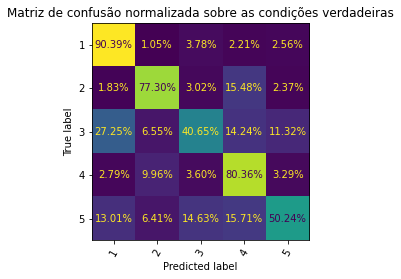

In [202]:
imprimeMatrizDeConfusão(y_test, preds_rf_RG, rf_RandomGrid)

In [194]:
## Busca pelo melhor hiperparametro
def tune_rf(params):
    n_estimators = params[0]
    max_features = params[1]
    max_depth = params[2]
    criterion = params[3]
    min_samples_split = params[4]
    min_samples_leaf = params[5]
    bootstrap = params[6]
    
    print(params, '\n')
    
    rf_Model = RandomForestClassifier(n_estimators=n_estimators, max_features=max_features, max_depth=max_depth, criterion=criterion, min_samples_split=min_samples_split,
                                       min_samples_leaf = min_samples_leaf, bootstrap=bootstrap, random_state=0, n_jobs=-1)
    
    auc = cross_val_score(rf_Model, X_train, y_train, cv=3, scoring ='accuracy')
    
    return -auc.mean()

space = [ np.arange(50, 250, 50), # n_estimators
         ['auto', 'sqrt'], # max_features
         [50, 100, 150, None], # max_depth
         ['gini', 'entropy'], # criterion
         [2, 5, 10, 30, 50], # min_samples_split
         [1,2,4], # min_samples_leaf
         [True, False]] # bootstrap] 

In [195]:
%%time
from skopt import forest_minimize
resultado_rf = gp_minimize(tune_rf, space, random_state=0, verbose=1, n_calls=30, n_random_starts=15, n_jobs=-1)

Iteration No: 1 started. Evaluating function at random point.
[150, 'sqrt', None, 'gini', 10, 2, False] 

Iteration No: 1 ended. Evaluation done at random point.
Time taken: 39.5216
Function value obtained: -0.7202
Current minimum: -0.7202
Iteration No: 2 started. Evaluating function at random point.
[50, 'auto', 100, 'gini', 10, 2, True] 

Iteration No: 2 ended. Evaluation done at random point.
Time taken: 7.7922
Function value obtained: -0.7222
Current minimum: -0.7222
Iteration No: 3 started. Evaluating function at random point.
[100, 'sqrt', 100, 'gini', 5, 4, False] 

Iteration No: 3 ended. Evaluation done at random point.
Time taken: 26.2323
Function value obtained: -0.7207
Current minimum: -0.7222
Iteration No: 4 started. Evaluating function at random point.
[150, 'sqrt', 150, 'gini', 10, 2, True] 

Iteration No: 4 ended. Evaluation done at random point.
Time taken: 26.4397
Function value obtained: -0.7244
Current minimum: -0.7244
Iteration No: 5 started. Evaluating function at 

In [203]:
# Retorna o melhor hiperparametro
# Em ordem: n_estimators, max_features, max_depth, criterion, min_samples_split, min_samples_leaf, bootstrap
resultado_rf.x

[200, 'sqrt', 50, 'entropy', 10, 1, True]

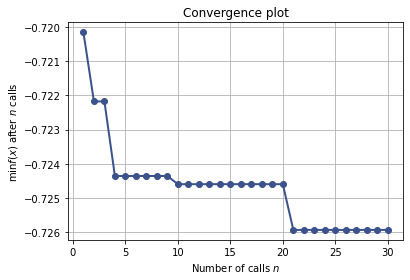

In [197]:
from skopt.plots import plot_convergence
plot_convergence(resultado_rf)

In [204]:
# Inserir manualmente os melhores hiperparametros
%%time
rf_model = RandomForestClassifier(n_estimators=200, max_features='sqrt', max_depth=50, criterion='entropy',
                                  min_samples_split=10, min_samples_leaf=1 , bootstrap=True, random_state=0, n_jobs=-1)
rf_model.fit(X_train, y_train)
preds = rf_model.predict(X_test)

CPU times: user 39.7 s, sys: 245 ms, total: 39.9 s
Wall time: 23.1 s


In [205]:
# Retorna a acurácia
accuracy_score(y_test, preds)*100

73.51987281399046

In [206]:
# Retorna a tabela com alguns resultados
# digits= define quantidade de casas após a virgula
print(classification_report(y_test, preds, digits=4))

              precision    recall  f1-score   support

           1     0.8149    0.9037    0.8570      5153
           2     0.7645    0.7741    0.7692      2784
           3     0.6088    0.4105    0.4903      2536
           4     0.7145    0.8039    0.7566      3584
           5     0.5707    0.4958    0.5306      1668

    accuracy                         0.7352     15725
   macro avg     0.6947    0.6776    0.6808     15725
weighted avg     0.7239    0.7352    0.7248     15725



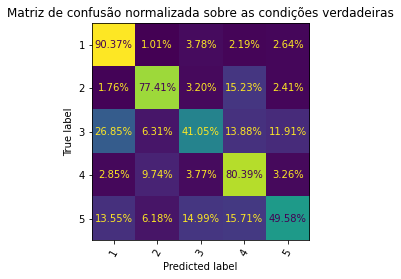

In [207]:
imprimeMatrizDeConfusão(y_test, preds, rf_model)

**Tilt**

In [225]:
# Lista com os atributos aplicáveis - colunas
features_aplicaveis = ['gx', 'gy', 'gz ', 'Comportamento']

In [226]:
# Seleciona os abributos correspondentes da lista features_aplicaveis
df = df[features_aplicaveis]

In [227]:
def imprimir_quantidade_dados(X_train, X_test):
    print(10*"-"," Quantidade de dados ",  10*"-")
    
    print('Treino: ', X_train.shape[0])
    print('Teste: ', X_test.shape[0])
    
    print(43*"-")

In [228]:
y = df.Comportamento
X = df.drop('Comportamento', axis=1)

# Conjunto de dados PRO: Pastejando x Ruminando x Ócio
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state = 0, stratify=y)

In [229]:
imprimir_quantidade_dados(X_train, X_test)

----------  Quantidade de dados  ----------
Treino:  62896
Teste:  15725
-------------------------------------------


In [230]:
# Função para imprimir e salvar matriz de confusão
def imprimeMatrizDeConfusão(y_test, preds, model, salvarFigura = False):
    from sklearn.metrics import confusion_matrix
    from sklearn.metrics import ConfusionMatrixDisplay
    import matplotlib.pyplot as plt

    cm = confusion_matrix(y_test, preds, normalize='true')
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    disp.plot(values_format= '.2%', xticks_rotation=60, colorbar=False)
    disp.ax_.set_title("Matriz de confusão normalizada sobre as condições verdadeiras")
    if(salvarFigura):
        plt.savefig(input('Nome da figura a ser salva:' ) + '.png')
    plt.show()

In [231]:
from sklearn.metrics import classification_report

def classification_report_extendido(y_true: np.array, y_pred: np.array, classes: set = None):
    report = classification_report(y_true, y_pred, output_dict=True, zero_division=0)
    
    if classes is None: # Determina classes pelos valores
        classes = set(np.concatenate((np.unique(y_true), np.unique(y_pred))))
    for cls in classes:
        y_true_cls = (y_true == cls).astype(int)
        y_pred_cls = (y_pred == cls).astype(int)

        fp = sum(y_pred_cls[y_true_cls != 1])
        tn = sum(y_pred_cls[y_true_cls == 0] == False)
        fn = sum(y_pred_cls[y_true_cls == 1] == False)

        
        specificity_val = tn / (tn + fp)
        report[cls]['specificity'] = specificity_val
        npv_val = tn / (tn + fn)
        report[cls]['npv'] = npv_val
        
    return report

RF

In [232]:
# imports
from sklearn.ensemble import RandomForestClassifier

In [233]:
rf_Model = RandomForestClassifier(random_state=0, n_jobs=-1)

In [234]:
# criação de um grid
rf_param_grid = {'n_estimators':  np.arange(50, 250, 50),
               'max_features': ['auto', 'sqrt'],
               'max_depth':[50, 100, 150, None],
               'criterion': ['gini', 'entropy'],
               'min_samples_split': [2, 5, 10, 30, 50],
               'min_samples_leaf': [1, 2],
               'bootstrap': [True, False]}

In [235]:
rf_RandomGrid = RandomizedSearchCV(estimator = rf_Model, param_distributions = rf_param_grid, cv = 3, verbose=1, random_state=0)

In [236]:
# Identificação do melhor hiperparametro para testes iniciais
%%time
rf_RandomGrid.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
CPU times: user 1min 22s, sys: 4.33 s, total: 1min 26s
Wall time: 6min 56s


RandomizedSearchCV(cv=3,
                   estimator=RandomForestClassifier(n_jobs=-1, random_state=0),
                   param_distributions={'bootstrap': [True, False],
                                        'criterion': ['gini', 'entropy'],
                                        'max_depth': [50, 100, 150, None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2],
                                        'min_samples_split': [2, 5, 10, 30, 50],
                                        'n_estimators': array([ 50, 100, 150, 200])},
                   random_state=0, verbose=1)

In [237]:
# Retorna o melhor hiperparametro
rf_RandomGrid.best_params_

{'n_estimators': 200,
 'min_samples_split': 50,
 'min_samples_leaf': 2,
 'max_features': 'sqrt',
 'max_depth': 150,
 'criterion': 'entropy',
 'bootstrap': True}

In [238]:
# Acurácia com o melhor hiperparametro pata teste inicial
rf_RandomGrid.best_score_

0.49710631025028756

In [239]:
preds_rf_RG = rf_RandomGrid.predict(X_test)

In [240]:
accuracy_score(y_test, preds_rf_RG)*100

49.63434022257552

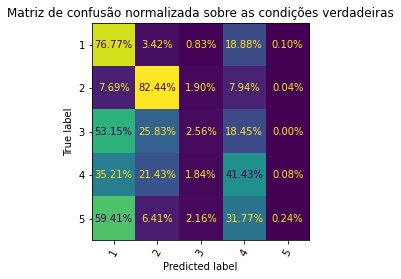

In [241]:
imprimeMatrizDeConfusão(y_test, preds_rf_RG, rf_RandomGrid)

In [242]:
## Busca por hiperparametro
def tune_rf(params):
    n_estimators = params[0]
    max_features = params[1]
    max_depth = params[2]
    criterion = params[3]
    min_samples_split = params[4]
    min_samples_leaf = params[5]
    bootstrap = params[6]
    
    print(params, '\n')
    
    rf_Model = RandomForestClassifier(n_estimators=n_estimators, max_features=max_features, max_depth=max_depth, criterion=criterion, min_samples_split=min_samples_split,
                                       min_samples_leaf = min_samples_leaf, bootstrap=bootstrap, random_state=0, n_jobs=-1)
    
    auc = cross_val_score(rf_Model, X_train, y_train, cv=3, scoring ='accuracy')
    
    return -auc.mean()

space = [ np.arange(50, 250, 50), # n_estimators
         ['auto', 'sqrt'], # max_features
         [50, 100, 150, None], # max_depth
         ['gini', 'entropy'], # criterion
         [2, 5, 10, 30, 50], # min_samples_split
         [1,2,4], # min_samples_leaf
         [True, False]] # bootstrap] 

In [243]:
%%time
from skopt import forest_minimize
resultado_rf = gp_minimize(tune_rf, space, random_state=0, verbose=1, n_calls=30, n_random_starts=15, n_jobs=-1)

Iteration No: 1 started. Evaluating function at random point.
[150, 'sqrt', None, 'gini', 10, 2, False] 

Iteration No: 1 ended. Evaluation done at random point.
Time taken: 42.3610
Function value obtained: -0.4717
Current minimum: -0.4717
Iteration No: 2 started. Evaluating function at random point.
[50, 'auto', 100, 'gini', 10, 2, True] 

Iteration No: 2 ended. Evaluation done at random point.
Time taken: 8.8161
Function value obtained: -0.4833
Current minimum: -0.4833
Iteration No: 3 started. Evaluating function at random point.
[100, 'sqrt', 100, 'gini', 5, 4, False] 

Iteration No: 3 ended. Evaluation done at random point.
Time taken: 27.5078
Function value obtained: -0.4727
Current minimum: -0.4833
Iteration No: 4 started. Evaluating function at random point.
[150, 'sqrt', 150, 'gini', 10, 2, True] 

Iteration No: 4 ended. Evaluation done at random point.
Time taken: 29.2837
Function value obtained: -0.4851
Current minimum: -0.4851
Iteration No: 5 started. Evaluating function at 

In [244]:
# Retorna o melhor hiperparametro
# Em ordem: n_estimators, max_features, max_depth, criterion, min_samples_split, min_samples_leaf, bootstrap
resultado_rf.x

[150, 'sqrt', None, 'entropy', 50, 1, True]

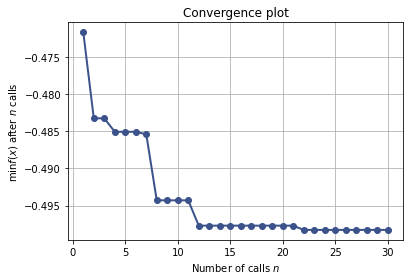

In [245]:
from skopt.plots import plot_convergence
plot_convergence(resultado_rf)

In [246]:
# Inserir manualmente os melhores hiperparametros
%%time
rf_model = RandomForestClassifier(n_estimators=150, max_features='sqrt', max_depth=None, criterion='entropy',
                                  min_samples_split=50, min_samples_leaf=1 , bootstrap=True, random_state=0, n_jobs=-1)
rf_model.fit(X_train, y_train)
preds = rf_model.predict(X_test)

CPU times: user 28.4 s, sys: 55.1 ms, total: 28.5 s
Wall time: 16.4 s


In [ ]:
# Retorna a acurácia
accuracy_score(y_test, preds)*100

In [ ]:
# Retorna a tabela com alguns resultados
# digits= define quantidade de casas após a virgula
print(classification_report(y_test, preds, digits=5))

In [ ]:
imprimeMatrizDeConfusão(y_test, preds, rf_model)